# Week 13: Attention Mechanisms

This notebook introduces attention mechanisms, a key building block for modern sequence-to-sequence models and transformers. You'll implement scaled dot-product attention from scratch and visualize how attention weights focus on relevant parts of input sequences.

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Display configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

In [2]:
import os
import pickle

# ── Cache helpers ─────────────────────────────────────────────────────────────
CACHE_DIR = "cache_week13"
os.makedirs(CACHE_DIR, exist_ok=True)

def save_result(key, obj):
    with open(os.path.join(CACHE_DIR, f"{key}.pkl"), "wb") as f:
        pickle.dump(obj, f)

def load_result(key):
    path = os.path.join(CACHE_DIR, f"{key}.pkl")
    if os.path.exists(path):
        with open(path, "rb") as f:
            return pickle.load(f)
    return None

def cached(key, compute_fn):
    result = load_result(key)
    if result is not None:
        print(f"[cache] Loaded '{key}'")
        return result
    print(f"[cache] Computing '{key}' …")
    result = compute_fn()
    save_result(key, result)
    return result

def save_model(model, name):
    path = os.path.join(CACHE_DIR, f"{name}.pth")
    torch.save(model.state_dict(), path)
    print(f"[cache] Model saved → {path}")

def load_model_state(name):
    path = os.path.join(CACHE_DIR, f"{name}.pth")
    if os.path.exists(path):
        print(f"[cache] Model loaded ← {path}")
        return torch.load(path, weights_only=True)
    return None


## Exercise 1: Scaled Dot-Product Attention from Scratch

Implement the core attention mechanism used in transformers.

In [3]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.
    
    Args:
        Q: Query matrix (batch_size, seq_len_q, d_k)
        K: Key matrix (batch_size, seq_len_k, d_k)
        V: Value matrix (batch_size, seq_len_v, d_v)
        mask: Optional mask (batch_size, seq_len_q, seq_len_k)
    
    Returns:
        output: Attention output (batch_size, seq_len_q, d_v)
        attention_weights: Attention weights (batch_size, seq_len_q, seq_len_k)
    """
    d_k = Q.shape[-1]
    
    # Compute attention scores: Q @ K^T / sqrt(d_k)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(d_k)
    
    # Apply mask if provided (set masked positions to -inf)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Compute weighted sum of values
    output = torch.matmul(attention_weights, V)
    
    return output, attention_weights

# Test with simple example
batch_size, seq_len, d_model = 2, 4, 8
Q = torch.randn(batch_size, seq_len, d_model)
K = torch.randn(batch_size, seq_len, d_model)
V = torch.randn(batch_size, seq_len, d_model)

output, attn_weights = scaled_dot_product_attention(Q, K, V)
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"Attention weights sum (should be ~1.0): {attn_weights[0].sum(dim=-1)}")

Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 4, 4])
Attention weights sum (should be ~1.0): tensor([1.0000, 1.0000, 1.0000, 1.0000])


## Exercise 2: Visualize Attention Weights

Create a heatmap to understand where the model is "looking".

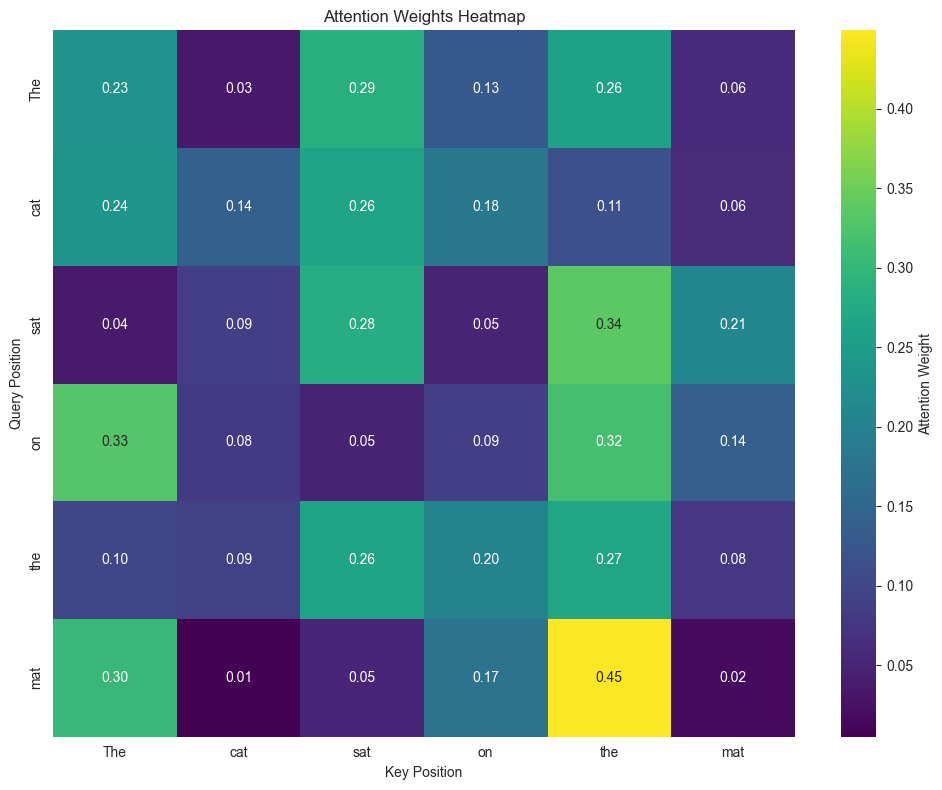

In [4]:
def visualize_attention(attention_weights, query_labels=None, key_labels=None):
    """
    Visualize attention weights as a heatmap.
    
    Args:
        attention_weights: (seq_len_q, seq_len_k) tensor
        query_labels: Optional labels for query positions
        key_labels: Optional labels for key positions
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attention_weights.detach().cpu().numpy(),
        cmap='viridis',
        annot=True,
        fmt='.2f',
        xticklabels=key_labels if key_labels else range(attention_weights.shape[1]),
        yticklabels=query_labels if query_labels else range(attention_weights.shape[0]),
        cbar_kws={'label': 'Attention Weight'}
    )
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.title('Attention Weights Heatmap')
    plt.tight_layout()
    plt.show()

# Create a simple attention example with meaningful labels
sentence = ['The', 'cat', 'sat', 'on', 'the', 'mat']
seq_len = len(sentence)
d_k = 16

# Create queries and keys (one per word)
Q_words = torch.randn(1, seq_len, d_k)
K_words = torch.randn(1, seq_len, d_k)
V_words = torch.randn(1, seq_len, d_k)

_, attn_weights_words = scaled_dot_product_attention(Q_words, K_words, V_words)

# Visualize attention for the first sequence
visualize_attention(attn_weights_words[0], query_labels=sentence, key_labels=sentence)

## Exercise 3: Multi-Head Attention

Implement multi-head attention to capture different types of relationships.

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Linear projections for Q, K, V
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        
        # Output projection
        self.W_o = nn.Linear(d_model, d_model)
    
    def split_heads(self, x):
        """Split last dimension into (num_heads, d_k)"""
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]
        
        # Linear projections
        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)
        
        # Split into multiple heads: (batch_size, num_heads, seq_len, d_k)
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Apply attention on each head
        attn_output, attn_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenate heads: (batch_size, seq_len, d_model)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        # Apply output projection
        output = self.W_o(attn_output)
        
        return output, attn_weights

# Test multi-head attention
d_model = 64
num_heads = 8
batch_size, seq_len = 2, 10

mha = MultiHeadAttention(d_model, num_heads)
x = torch.randn(batch_size, seq_len, d_model)

output, attn_weights = mha(x, x, x)
print(f"Multi-head attention output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"Number of parameters: {sum(p.numel() for p in mha.parameters()):,}")

Multi-head attention output shape: torch.Size([2, 10, 64])
Attention weights shape: torch.Size([2, 8, 10, 10])
Number of parameters: 16,640


## Exercise 4: Simple Seq2Seq with Attention

Build a sequence-to-sequence model with attention for a toy task (e.g., reversing sequences).

In [6]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Encoder
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        
        # Attention
        self.attention = nn.Linear(hidden_dim * 2, 1)
        
        # Decoder
        self.decoder = nn.GRU(embed_dim + hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, src, tgt):
        # Encode source sequence
        src_embed = self.embedding(src)
        encoder_outputs, hidden = self.encoder(src_embed)
        
        # Decode with attention
        tgt_embed = self.embedding(tgt)
        batch_size, tgt_len, _ = tgt_embed.shape
        
        outputs = []
        for t in range(tgt_len):
            # Compute attention weights
            hidden_expanded = hidden.transpose(0, 1).expand(-1, encoder_outputs.shape[1], -1)
            attn_input = torch.cat([hidden_expanded, encoder_outputs], dim=-1)
            attn_scores = self.attention(attn_input).squeeze(-1)
            attn_weights = F.softmax(attn_scores, dim=-1)
            
            # Compute context vector
            context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
            
            # Decoder step
            decoder_input = torch.cat([tgt_embed[:, t:t+1, :], context.unsqueeze(1)], dim=-1)
            decoder_output, hidden = self.decoder(decoder_input, hidden)
            
            # Predict output
            output = self.output_layer(decoder_output)
            outputs.append(output)
        
        return torch.cat(outputs, dim=1)

# Create toy dataset: reverse sequences
vocab_size = 20
seq_len = 8
num_samples = 1000

# Generate random sequences and their reverses
src_data = torch.randint(1, vocab_size, (num_samples, seq_len))
tgt_data = torch.flip(src_data, dims=[1])

CACHE_KEY = "seq2seq_attention_5epochs"

_state = load_model_state(CACHE_KEY)
if _state is not None:
    model = Seq2SeqWithAttention(vocab_size, embed_dim=32, hidden_dim=64)
    model.load_state_dict(_state)
    history = load_result(CACHE_KEY + "_history")
    print("[cache] Seq2Seq model and history loaded — skipping training.")
else:
    model = Seq2SeqWithAttention(vocab_size, embed_dim=32, hidden_dim=64)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    dataset = TensorDataset(src_data, tgt_data)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    history = []
    model.train()
    for epoch in range(5):
        total_loss = 0
        for src_batch, tgt_batch in dataloader:
            optimizer.zero_grad()
            output = model(src_batch, tgt_batch)
            loss = criterion(output.view(-1, vocab_size), tgt_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}/5, Loss: {avg_loss:.4f}")

    save_model(model, CACHE_KEY)
    save_result(CACHE_KEY + "_history", history)

# Test on a few examples
model.eval()
with torch.no_grad():
    test_src = src_data[:3]
    test_tgt = tgt_data[:3]
    predictions = model(test_src, test_tgt)
    predicted_tokens = predictions.argmax(dim=-1)
    
    for i in range(3):
        print(f"\nSource:    {test_src[i].tolist()}")
        print(f"Target:    {test_tgt[i].tolist()}")
        print(f"Predicted: {predicted_tokens[i].tolist()}")


Epoch 1/5, Loss: 2.6026
Epoch 2/5, Loss: 1.3665
Epoch 3/5, Loss: 0.3641
Epoch 4/5, Loss: 0.1184
Epoch 5/5, Loss: 0.0605
[cache] Model saved → cache_week13\seq2seq_attention_5epochs.pth

Source:    [12, 11, 14, 4, 9, 9, 16, 15]
Target:    [15, 16, 9, 9, 4, 14, 11, 12]
Predicted: [15, 16, 9, 9, 4, 14, 11, 12]

Source:    [19, 5, 11, 7, 6, 8, 14, 2]
Target:    [2, 14, 8, 6, 7, 11, 5, 19]
Predicted: [2, 14, 8, 6, 7, 11, 5, 19]

Source:    [5, 14, 4, 18, 15, 12, 4, 7]
Target:    [7, 4, 12, 15, 18, 4, 14, 5]
Predicted: [7, 4, 12, 15, 18, 4, 14, 5]


## Further Practice

1. **Causal Masking**: Implement a causal mask for autoregressive generation (prevent attending to future tokens)
2. **Cross-Attention**: Modify the implementation to support cross-attention (different Q vs K,V sources)
3. **Attention Patterns**: Visualize attention weights across different heads in multi-head attention
4. **Complexity Analysis**: Measure time/memory for different sequence lengths and attention dimensionalities

## Deliverables

- [ ] Implement scaled dot-product attention from scratch
- [ ] Visualize attention weights as heatmaps
- [ ] Build multi-head attention module
- [ ] Train seq2seq model with attention on toy task
- [ ] Compare attention vs non-attention seq2seq performance
- [ ] Analyze attention patterns on several examples

In [7]:

# EXERCISE 1 — Causal (Auto-Regressive) Mask
# Goal: implement a causal mask so each position can only attend to itself and earlier positions.
# Apply it to scaled_dot_product_attention and verify by checking that the upper triangle
# of attn_weights is zero (no future leakage).
# Use cached("causal_attention_demo", ...) to store the resulting weight matrix for quick reload.


In [8]:

# EXERCISE 2 — Cross-Attention (Encoder–Decoder)
# Goal: build a cross-attention layer where Q comes from the decoder hidden state
# and K, V come from the encoder output (different source from Q).
# Verify shapes for sequences of different lengths (src_len ≠ tgt_len).
# Visualize cross-attention weights as a heatmap with tokens on both axes.


In [9]:

# EXERCISE 3 — Multi-Head Attention Pattern Analysis
# Goal: run multi-head attention on a real sentence (tokenized as integer IDs, length ~12).
# For each of the 8 heads, plot the attention heatmap using visualize_attention().
# Identify which heads attend locally (nearby tokens) vs globally (all positions equally).
# Use cached("multihead_patterns_8heads", ...) to store the list of per-head weight matrices.


In [10]:

# EXERCISE 4 — Attention vs No-Attention Seq2Seq Comparison
# Goal: build a vanilla GRU Seq2Seq (no attention) and train it on the same reverse-sequence task.
# Compare validation accuracy against the attention model after 5 epochs.
# Use cached("seq2seq_no_attention_5epochs", ...) and cached("seq2seq_attention_5epochs_history", ...)
# to store each training history, then plot both loss curves side-by-side.


## Recommended Resources

- [Attention Is All You Need](https://arxiv.org/abs/1706.03762) (original Transformer paper)
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) (visual guide)
- [Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/) (Distill article)